# Lab 5: Dissecting the Role of Algorithms in Fragment-based Drug Discovery

Review the lab material and go through the entire notebook.
The lab contains 5 exercises for you to solve. The entire lab is worth 2.5% of your final grade and each exercise is worth 0.4% of your final grade. Going through the full notebook is worth 0.5% of your final grade.
Any extra credit or bonus exercises are worth an additional 0.4%.

Labs are due by Friday at 11:59 PM PST and can be submitted on BCourses assignment page for the corresponding lab.

## Setup

Run the below steps at the beginning of lab to set up required packages.

In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 52.0 MB/s eta 0:00:00


In [2]:
import itertools, math, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem, ChemicalFeatures, DataStructs, MolToSmiles, PandasTools, rdFingerprintGenerator
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.ML.Cluster import Butina
from rdkit.RDPaths import RDDataDir
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist, pdist, squareform
from tqdm import tqdm
from typing import List, Tuple

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

colors = ["#A20025", "#6C8EBF"]
sns.set_palette(sns.color_palette(colors))

## COVID Moonshot Campaign

In this lab, we'll focus on an application stemming from the COVID Moonshot campaign [1]. The COVID Moonshot campaign is an open-science initiative to accelerate discovery of antiviral drugs targeting inhibition of the SARS-CoV-2 main protease (Mpro). Inhibition of Mpro prevents viral replication of SARS-CoV-2, with precedence for clinical success set by Paxlovid and Ensitrelvir [2,3]. The campaign used high-throughput screening (HTS) techniques to evaluate thousands of compounds with respect to Mpro inhibition, optimizing promising compounds through iterative cycles of design, synthesis, and testing.

The COVID Moonshot incorporated many components, from crowdsourcing over 18,000 designs and judging those designs based on synthetic feasibility and estimated activity, to synthesizing over 2000 of those designs and conducting several types of high-throughput assays and crystallography experiments to determine their structure and viability as leads. We will focus solely on the set of 2,062 synthesized compounds whose IC50 was experimentally measured via HTS.

IC50 is the concentration of a compound required to inhibit 50% of protein activity. Ideally, a compound is effective even at low concentrations to avoid undesired interactions with other proteins.


The following code loads in the data set, which we have already processed by:
1. Computing Morgan fingerprints (2048 bits at radius of 2) for each compound
2. Using a cut-off of 5 μM IC50, based on literature that we’ll discuss later, to define active and inactive compounds. Compounds that did not have a measured IC50 are still present in the data set but are labeled as "Unknown."

Make sure that you create a "data" folder and upload both files to the folder:
- L02_activity_data.csv
- L02_morgan_fingerprints.npy

In [4]:
data = pd.read_csv('data/L02_activity_data.csv')
fingerprints = np.load('data/L02_morgan_fingerprints.npy')
label_names = {1:'Active', 2:'Inactive', 3:'Unknown'}

In [5]:
data.head()

,SMILES,CID,canonical_CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50,relative_solubility_at_20_uM,relative_solubility_at_100_uM,trypsin_IC50,NMR_std_ratio,acrylamide,chloroacetamide,series,frag_id,Morgan_Fingerprint,label
0,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,LUO-POS-e1dab717-11,LUO-POS-e1dab717-11,NaN,NaN,NaN,NaN,NaN,0.275118,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2
1,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,LUO-POS-e1dab717-12,LUO-POS-e1dab717-12,NaN,NaN,NaN,NaN,NaN,0.202767,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2
2,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,MAT-POS-e48723dc-1,MAT-POS-e48723dc-1,NaN,NaN,NaN,NaN,NaN,55.453947,NaN,NaN,NaN,NaN,NaN,False,False,Ugi,NaN,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,1
3,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,MAT-POS-e48723dc-2,MAT-POS-e48723dc-2,NaN,NaN,NaN,NaN,NaN,0.050000,NaN,NaN,NaN,NaN,NaN,False,False,Ugi,NaN,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2
4,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,LUO-POS-9931618f-2,LUO-POS-9931618f-2,NaN,NaN,NaN,NaN,NaN,0.052757,NaN,NaN,NaN,NaN,NaN,False,False,Ugi,NaN,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2


## High Throughput Screening (HTS) Data

In this scenario, we want to identify a new antiviral that can stop COVID-19. With advancements in robotic and miniaturization techniques, HTS is capable of handling a high volume of thousands of tiny tests at once and in an automated fashion. In early stages of HTS, single-shot inhibition data provides a quick assessment of each compound’s activity against the target. A single concentration, which is relatively high to maximize the chance of detecting any inhibition, is selected. Each compound from a large library of compounds is tested at this concentration, and the inhibition of the target’s activity is measured. Compounds that exhibit significant inhibition at the single concentration are flagged as potential hits for follow-up studies.

If resource and time requirements permit, we can measure each compound’s activity at multiple concentrations to construct dose response curves. Dose response curves plot the compound’s inhibitory activity on the target against different concentrations of the compound, from which we can determine key parameters such as IC50. For example, the COVID Moonshot program determined IC50 from dose response curves that used an 11-point range of 100—0.0017 µM inhibitor concentrations, ensuring that both high and low efficacy could be measured.

To determine the IC50 for each compound, the Moonshot program used the Levenberg-Marquardt algorithm to fit a restrained Hill equation to each compound’s dose response curve. Let’s break these concepts down. The Hill equation is a mathematical model to describe the relationship between the compound’s concentration and the expected response:

$E=\frac{(E_{max} [I]^n)}{(IC_{50}^n+[I]^n)}$

- $E$ is the observed response.
- $E_{max}$  is the maximum response.
- $[I]$ is the concentration of the compound.
- $IC_{50}$ is the concentration at which the response is half of $E_{max}$.
- $n$ is the Hill coefficient, which describes the slope of the curve.


We can use the Levenberg-Marquardt algorithm to fit a non-linear model of our HTS data. In the context of the Hill equation, the Levenberg-Marquardt algorithm is useful since it accounts for the non-linear nature of the dose-response relationship. At a high-level, we start with initial guesses for the parameters in the Hill equation ($E_{max}$, $[I]$, $n$) and we iteratively adjust the parameters to minimize the error between the observed data points and the model’s predictions via a combination of gradient descent and the Gauss-Newton method. A restrained fit means that certain parameters are kept within specified, realistic bounds to ensure that the resultant IC50 value is reliable and biologically meaningful.

### Exercise 1: Levenberg-Marquardt Algorithm

The following code block will plot a figure that demonstrates the sigmoidal shape common to dose-response curves, a fitted Hill equation, and which point on the fitted curve corresponds to the IC50 value. This figure is based on an arbitrary, toy data set.

Your task is to complete the missing sections of the code block (where a `TODO` comment is present). Once you have added the correct code, it will output the same figure as shown here:

![UN01](https://github.com/nrflynn2/swe-molecular-sciences/blob/main/figures/L02_UN01_Flynn.png?raw=1)

### Student Solution to Exercise 1

Provide your solution to the above exercise in this cell and/or immediately following cells.

Fitted parameters:
E_max: 93.38453452061374
IC50: 0.07799836455235021
Hill coefficient (n): 0.6707229452417185


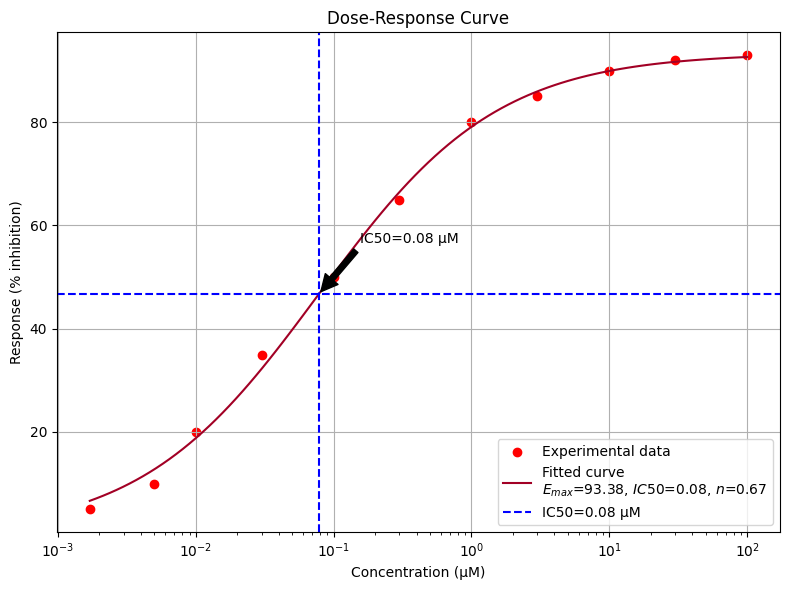

In [7]:
# Synthetic dose-response data
concentrations = np.array([0.0017, 0.005, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100])  # in µM
responses = np.array([5, 10, 20, 35, 50, 65, 80, 85, 90, 92, 93])  # arbitrary units, % inhibition for example

# Initial guesses for E_max, IC50, and Hill coefficient (n)
initial_guesses = [100, 1, 1]

# Constraints: E_max between 0 and 100, IC50 between 0 and 100, n between 0.1 and 3
param_bounds = ([0, 0, 0.1], [100, 100, 3])

# Hill equation function
def hill_equation(conc, E_max, IC50, n):
    """
    Calculate response using the Hill equation
    conc: drug concentration
    E_max: maximum effect
    IC50: concentration producing 50% of max effect
    n: Hill coefficient (steepness)
    """
    # TODO: Implement the Hill hill_equation
    E = E_max * conc ** (n) / ((IC50 ** (n)) + (conc ** (n)))
    return E


# Fit the Hill equation to the data using the Levenberg-Marquardt algorithm
popt, pcov = curve_fit(hill_equation, concentrations, responses,
                      p0=initial_guesses,
                      bounds=param_bounds,
                      method='trf')

# Extract the optimal parameters
E_max_opt, IC50_opt, n_opt = popt

# Generate data for the fitted curve, then plot it
concentration_range = np.logspace(np.log10(concentrations.min()), np.log10(concentrations.max()), 100)
fitted_responses = hill_equation(concentration_range, *popt)

plt.figure(figsize=(8, 6))
plt.scatter(concentrations, responses, color='red', label='Experimental data')
plt.plot(concentration_range, fitted_responses, label=f'Fitted curve\n$E_{{max}}$={E_max_opt:.2f}, $IC50$={IC50_opt:.2f}, $n$={n_opt:.2f}')
plt.xscale('log')
plt.xlabel('Concentration (µM)')
plt.ylabel('Response (% inhibition)')
plt.title('Dose-Response Curve')
plt.legend()
plt.grid(True)

# To get the IC50 response, return the output if hill_equation using a combination of the parameters IC50_opt, E_max_opt, IC50_op, and n_opt
ic50_response = hill_equation(IC50_opt, E_max_opt, IC50_opt, n_opt)
plt.axhline(y=ic50_response, color='blue', linestyle='--', label=f'IC50={IC50_opt:.2f} µM')
plt.axvline(x=IC50_opt, color='blue', linestyle='--')
plt.annotate(f'IC50={IC50_opt:.2f} µM',
             xy=(IC50_opt, ic50_response),
             xytext=(IC50_opt*2, ic50_response+10),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()
plt.tight_layout()

print(f"Fitted parameters:\nE_max: {E_max_opt}\nIC50: {IC50_opt}\nHill coefficient (n): {n_opt}")

HTS presents a high volume of data at our doorstep, but with additional confounders in the form of greater levels of experimental noise and greater diversity in the chemical structures within the compound library. We'd like to extrapolate the HTS data on these compounds to novel compounds. In the next section, we'll consider a few approaches to generating a compound library with novel compounds.

## Curating Diverse Compound Libraries

In lab 1, we used the similar property principle to search for compounds within a screening library that had high structural similar to known antimalarial compounds, with the hope that such compounds would exhibit similar antimalarial properties. In this section, we’ll consider how similarity, and diversity, play fundamental roles in the design of compound libraries.

### Diversity and Focus

The concept of creating representative sets of compounds is a critical strategy in the pharmaceutical industry. Consider a scenario where we have conducted a virtual screening campaign but have limited resources to experimentally test only a few compounds in a confirmatory assay. To maximize the information obtained from this screen, we select a diverse set of compounds. This might mean picking one representative from each chemical series in our list of potentially active compounds, ensuring that the selected compounds span the broadest range of chemical diversity.

Alternatively, we might focus on a single chemical series to delve into the structure-activity relationship within that series. By systematically testing compounds within the same series, we can gain detailed insights into how small structural changes drive biological activity, thus informing future optimization and development efforts. When designing compound libraries, we strike a balance between diversity and focus:

  - Diversity, i.e., maximizing exploration: More structurally diverse libraries provide greater coverage over the expanse of chemical space that we want to explore, maximizing the number of compounds with different activities and minimizing the number of redundant compounds with similar activities. We place greater emphasis on diversity when we expect our compound library to be used to screen against a broad set of biological targets or when we don’t have much prior information about the therapeutic target of interest.
  - Focus, i.e., maximizing exploitation: Focused libraries restrict our navigation of chemical space to a narrower region. We place greater emphasis on focused libraries when we know more about the downstream use case, incorporating as much information about the therapeutic target (such as its 3D structure, if available) to maximize our hit rate. Focused libraries provide higher hit rates, but these starting points may have greater redundancy in activity or function.

There is not a single, authoritative definition or quantification of chemical diversity. There are many methods for assessing the internal diversity of the molecules in our library, as well as the diversity of those molecules compared to external data sets from prior screens. We can quantify diversity as a function of any molecular descriptors or scaffolds, and how we measure diversity will also impact how we sample which molecules are to be included in the library.

Once we’ve settled on which descriptors we want to use to characterize our molecules and how we want to measure the aggregate diversity of the molecules we are considering, we can construct each subset of size K from the total number of molecules, N, that we are considering, measure each subset’s diversity, and keep the subset with greatest diversity. If we want to construct a library of 100 molecules from an initial set of 500 molecules, we’d need to evaluate ${N \choose K}={500 \choose 100}=2*10^{107}$ subsets. This is not realistic.

Later in this lab, we'll lean on machine learning to help resolve this sampling problem. Note that you aren't expected to know the mechanics of how any machine learning algorithms work, we are just using them to move the lab forward!


### Molecular Fragments

Before we can select a diverse subset of compounds, we have to establish the data source that these compounds are being selected from. Such data sources, typically large compound libraries, do not have to be pre-existing collections like the Specs library from lab 1. In the present, we’ll cover two classic approaches used to construct synthetic compound libraries, from which we can use as a basis to sample a diverse subset of compounds. If you find this subject interesting, you may want to explore the use of generative ML models to create synthetic compound libraries outside of this class.

The two classic approaches we will cover rely on understanding what a molecular fragment is. When we use the term “molecular fragment,” we are typically referring to a scaffold or an R-group. During drug design, medicinal chemists might identify a scaffold, or core, of their compounds that is essential to achieve the desired pharmacological effect. Compounds with the same scaffold often constitute a chemical series.

![UN02](https://github.com/nrflynn2/swe-molecular-sciences/blob/main/figures/L02_UN02_Flynn.svg?raw=1)

During optimization, the scaffold is typically kept constant while the substituents attached to the scaffold (the R-groups) are varied to improve the compound’s properties. Different R-groups can be attached to the same scaffold to create a library of analogs, which we can also use to explore how structural modifications to the compound affect its activity. This process is referred to as scaffold decoration.

In some cases, fundamental flaws inherent to the scaffold core arise, such as toxicity or patentability concerns. Scaffold hopping involves identifying entirely new scaffolds that exhibit similar biological activity as our current scaffold, while obviating their limitations. Note that we exchange the entire scaffold of the molecule while preserving the R-groups that were originally attached to it. Searching for alternative, novel scaffolds is harder than just adjusting the R-groups. From a modeling perspective, we must also consider that models exposed only to compounds with the old scaffold may not translate to reliable predictions on compounds with the new scaffold.

One application of scaffold hopping is to resolve intellectual property issues in drug repurposing. The original patent holders may have exclusive rights to the drug being repurposed, which can complicate IP ownership unless new patents for new indications can be obtained. If this interests you, check out Markush structures, which is a representation in chemical patents and IP claims that defines a broad class of chemical compounds by specifying variable parts of a molecule, allowing for the inclusion of multiple possible substituents or structural variations.

### Retrosynthetic Library Design

The COVID Moonshot project’s methodology was primarily concerned with developing a therapeutic as quickly as possible. In an (at the time) on-going pandemic, speed matters! Their aim was to make as many different ideas as possible for experimental follow ups, and so they prioritized compounds that could be rapidly synthesized by using ML to design synthetic schemes with uncertainty estimates.

Retrosynthetic library design safeguards against generation of compounds that are not synthesizable by baking in consideration of synthetic feasibility. We can use RDKit’s BRICS (Breaking of Retrosynthetically Interesting Chemical Substructures) module to both fragment compounds and generate new compounds by recombining these fragments based on common chemical reaction rules. Now we will construct a compound library based on retrosynethic library design. We will then use a model to screen against these synthetically generated compounds.

In [8]:
from rdkit.Chem import BRICS

data['mols'] = data['SMILES'].apply(Chem.MolFromSmiles)
frags = set([])
for mol in data['mols']:
    if mol is None: continue
    fragments = BRICS.BRICSDecompose(mol)    #A
    frags.update(fragments)

frag_mols = []
for frag in frags:
    frag_mol = Chem.MolFromSmiles(frag)
    if frag_mol:
        AllChem.Compute2DCoords(frag_mol)
        frag_mols.append(frag_mol)

rld_new_mols = []
for mol in BRICS.BRICSBuild(frag_mols, maxDepth=1):    #B
    if len(rld_new_mols) > 10000:    #C
        break
    try:
        Chem.SanitizeMol(mol)
        AllChem.Compute2DCoords(mol)
        rld_new_mols.append(mol)
    except:
        continue    #D
#A Decompose molecules into BRICS fragments and store unique fragments.
#B Call generator to build new molecules from the BRICS fragments with maximum depth of 1. The maximum depth corresponds to the number of reaction steps allowed to reach the new molecule.
#C Maximum depth greater than 3 will explode the number of potential molecules. Even with a depth of 1, we break early for convenience.
#D Skip molecules that cannot be sanitized.


### Exercise 2: Combinatorial & Retrosynthetic Library Design

Finish the implementation of a basic retrosynthetic analysis function that suggests possible precursors for a given string.

Test cases are provided to illustrate example inputs and outputs.

### Student Solution to Exercise 2

Provide your solution to the above exercise in this cell and/or immediately following cells.

In [11]:
def retrosynthetic_analysis(molecule):
    # TODO: your implementation
      """
      Performs a simplified retrosynthetic analysis on a given molecule string.
      Returns all possible two-fragment combinations that could form the target molecule.

      Args:
          molecule (str): A string representing the target molecule

      Returns:
          list: A list of tuples, where each tuple contains two strings representing
                possible precursor fragments (A, B) that could form the target molecule

      Example:
          >>> retrosynthetic_analysis("ABC")
          [('A', 'BC'), ('AB', 'C')]
      """
      if not molecule or len(molecule) < 2:
          return []

      # Generate all possible two-fragment combinations
      precursors = []

      # Iterate through all possible splitting points
      for i in range(1, len(molecule)):
          # Split molecule into two fragments
          fragment1 = molecule[:i]
          fragment2 = molecule[i:]

          # Add the precursor combination to our list
          precursors.append((fragment1, fragment2))

      return precursors

In [12]:
    # Test case 1: Basic splitting
    assert retrosynthetic_analysis("ABC") == [('A', 'BC'), ('AB', 'C')], "Test case 1 failed"

    # Test case 2: Empty string
    assert retrosynthetic_analysis("") == [], "Test case 2 failed"

    # Test case 3: Single character
    assert retrosynthetic_analysis("A") == [], "Test case 3 failed"

    # Test case 4: Two characters
    assert retrosynthetic_analysis("AB") == [('A', 'B')], "Test case 4 failed"

    # Test case 5: Longer string
    assert retrosynthetic_analysis("ABCD") == [
        ('A', 'BCD'),
        ('AB', 'CD'),
        ('ABC', 'D')
    ], "Test case 5 failed"

    print("All test cases passed!")

All test cases passed!


## An Introduction to Clustering

In this section, we will explore an important category of unsupervised machine learning models: clustering algorithms. Clustering algorithms can be used to produce an optimal division of our compound library into different clusters, where compounds within a cluster are more similar to each other than to compounds in other clusters.

In clustering, our model segments the data into similar subsets (where each subset is a cluster). The clustering model learns its own definition of classes, such that each cluster corresponds to a different class, and it learns which cluster to assign each data instance to.

One or more representative compounds can then be selected from each cluster to form our final, diverse compound library. Key aspects of cluster-based compound selection include:

1.	How we choose to represent the compounds, e.g., descriptors or fingerprints.
2.	What metric we use to assess the distance between each compound, given its representation.
3.	Our choice of clustering algorithm to segment the compounds.
4.	How we select a subset of compounds from each cluster depending on our problem requirements.

For simplicity, we’ll default to Morgan fingerprints of radius 2 and we’ll use the Tanimoto similarity coefficient, which we can use as a distance by subtracting the similarity coefficient from 1. A popular clustering algorithm for cheminformatics applications is Taylor-Butina clustering. We'll use both Taylor-Butina clustering and agglomerative clustering throughout the next section of the lab. The details of Taylor-Butina clustering and agglomerative clustering are out-of-scope for this course. Below, we use agglomerative clustering and Taylor-Butina clustering to sample a subset of molecules from the retrosynthetically constructed library.

The following code block defines useful functions for:
1. Converting molecules to fingerprints
    - The description by Butina for the Taylor-Butina clustering algorithm uses Daylight fingerprints, whose closest analog in the RDKit library is RDKit fingerprints of max path 5. This is why we use a different type of fingerprints.
2. Sampling compounds from each cluster
    - We will sample an equivalent number of compounds from each cluster to ensure that the sampled subset is representative of the original data set distribution. Within each cluster, we will sample the `n_samples` compounds that are closest to the cluster center, producing groupings of similar molecules within the sampled subset that will be easier for a downstream model to provide insights into structure-activity relationships.
3. Taylor-Butina clustering

In [13]:
# Convert RDKit molecules to Morgan fingerprints
def molecules_to_fingerprints(mols, radius=2, nBits=2048):
    rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5) # Daylight FP approximation
    fingerprints = [rdkit_gen.GetFingerprint(mol) for mol in mols]

    np_fps = []
    for fp in fingerprints:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        np_fps.append(arr)
    return np.array(np_fps), fingerprints

def sample_from_clusters(fps, clusters, n_samples=3):
    sampled_mols = []
    cluster_centers = []

    for cluster in clusters:
        if len(cluster) < n_samples:
            sampled_mols.extend(cluster)
        else:
            cluster_fps = [fps[i] for i in cluster]
            cluster_center = np.mean(cluster_fps, axis=0).reshape(1, -1)
            cluster_centers.append(cluster_center)

            distances = cdist(cluster_fps, cluster_center, metric='euclidean')
            closest_indices = np.argsort(distances.flatten())[:n_samples]
            sampled_mols.extend([cluster[i] for i in closest_indices])

    return sampled_mols

def butina_clustering(fingerprints, cutoff=0.2):
    dists = []
    nfps = len(fingerprints)
    for i in range(1, nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fingerprints[i], fingerprints[:i])
        dists.extend([1 - x for x in sims])
    cluster_data = Butina.ClusterData(dists, nfps, cutoff, isDistData=True)
    return cluster_data

The next two code blocks fit agglomerative clustering and Taylor-Butina clustering models, respectively, and sample separate sets of compounds for each methodology. Each code block may take a couple of minutes.

In [14]:
fps, rdkit_fps = molecules_to_fingerprints(rld_new_mols)

agg_model = AgglomerativeClustering(n_clusters=16, linkage='ward')
agg_model.fit(fps)
agg_clusters = [np.where(agg_model.labels_ == i)[0].tolist() for i in np.unique(agg_model.labels_)]

agg_sampled_indices = sample_from_clusters(fps, agg_clusters)
agg_sampled_molecules = [rld_new_mols[i] for i in agg_sampled_indices]

In [15]:
clusters = butina_clustering(rdkit_fps, cutoff=0.4)
cluster_labels = np.zeros(len(rld_new_mols))
for cluster_id, cluster in enumerate(clusters):
    for mol_id in cluster:
        cluster_labels[mol_id] = cluster_id

butina_sampled_indices = sample_from_clusters(fps, clusters)
butina_sampled_molecules = [rld_new_mols[i] for i in butina_sampled_indices]


### Exercise 3: Sorting in Taylor-Butina Clustering

In Taylor-Butina clustering, the following steps play critical roles in the algorithms performance:
1. Computing the pairwise similarity between all compounds.
2. Calculting the number of neighbors for each compound, where a neighbor is defined as another compound with a similarity that is above a specified threshold.
3. Sorting the compounds by their number of neighbors.

In this exercise, we implement two key functions:
1. tanimoto_similarity: Calculate the Tanimoto similarity between two binary fingerprints.
2. merge_sort: Implement the merge sort algorithm to sort fingerprints by their number of neighbors.

We then use these functions to analyze a set of molecular fingerprints.

**Part 1: Tanimoto Similarity**

Review the already implemented tanimoto_similarity function to calculate the similarity between two binary fingerprints.
Recall that Tanimoto similarity of two binary fingerprints is equal to: (intersection of bits) / (union of bits)

**Part 2: Merge Sort**

Implement the merge_sort function to sort fingerprints by their number of neighbors in descending order.
Hint: The merge function has already been implemented, which you can then use in the recursive merge_sort function.

**Part 3: Analysis**

Use your implemented functions to analyze the given set of molecular fingerprints by combining the Tanimoto similarity calculation with sorting. Specifically, calculate the number of neighbors for each fingerprint and sort them using your merge sort function. This functionality is already implemented for you.


### Student Solution to Exercise 3

Provide your solution to the above exercise in this cell and/or immediately following cells.

In [18]:
import random

# Helper function to generate random fingerprints of a more manageable length
def generate_fingerprint(length=64):
    return ''.join(random.choice('01') for _ in range(length))

# Part 1: Implement Tanimoto Similarity
def tanimoto_similarity(fp1, fp2):
    """
    Calculate the Tanimoto similarity between two binary fingerprints.

    :param fp1: First fingerprint (string of '0's and '1's)
    :param fp2: Second fingerprint (string of '0's and '1's)
    :return: Tanimoto similarity (float between 0 and 1)
    """
    if len(fp1) != len(fp2):
      raise ValueError("Fingerprints must be of equal length")

    # Convert binary strings to sets of indices where bits are 1
    set1 = set(i for i, bit in enumerate(fp1) if bit == '1')
    set2 = set(i for i, bit in enumerate(fp2) if bit == '1')

    # Calculate intersection and union
    intersection = len(set1 & set2)
    union = len(set1 | set2)

    # Handle edge case where both fingerprints are all zeros
    if union == 0:
        return 1.0 if fp1 == fp2 else 0.0

    return intersection / union

# Part 2: Implement Merge Sort
def merge(left, right, key_func):
    """
    Merge two sorted lists into a single sorted list.

    :param left: Left sorted list
    :param right: Right sorted list
    :param key_func: Function to compute the sort key
    :return: Merged sorted list
    """
    result = []
    i = j = 0

    while i < len(left) and j < len(right):
        if key_func(left[i]) >= key_func(right[j]):
            result.append(left[i])
            i += 1
        else:
            result.append(right[j])
            j += 1

    # Add remaining elements
    result.extend(left[i:])
    result.extend(right[j:])
    return result

def merge_sort(arr, key_func):
    """
    Sort the given array using the merge sort algorithm.

    :param arr: Array to be sorted
    :param key_func: Function to compute the sort key
    :return: Sorted array
    """
    # TODO: Implement merge sort algorithm
    # Base case: arrays of length 0 or 1 are already sorted
    if len(arr) <= 1:
      return arr

    # Split array into two halves
    middle = len(arr) // 2

    # Recursively sort both halves
    left = merge_sort(arr[:middle], key_func)
    right = merge_sort(arr[middle:], key_func)

    # Merge the sorted halves

    return merge(left, right, key_func)


# Part 3: Analysis
def analyze_fingerprints(fingerprints, similarity_threshold):
    """
    Analyze the given fingerprints using Tanimoto similarity and sort them by number of neighbors.

    :param fingerprints: List of fingerprints to analyze
    :param similarity_threshold: Threshold for considering fingerprints as neighbors
    :return: Sorted list of (fingerprint, neighbor_count) tuples
    """
    neighbor_counts = []
    for i, fp1 in enumerate(fingerprints):
        count = sum(1 for j, fp2 in enumerate(fingerprints)
                    if i != j and tanimoto_similarity(fp1, fp2) >= similarity_threshold)
        neighbor_counts.append((fp1, count))

    return merge_sort(neighbor_counts, key_func=lambda x: x[1])

In [19]:
# Test the implementation
def run_tests():
    print("Running tests...")

    # Test Tanimoto similarity
    assert abs(tanimoto_similarity('1010', '1100') - 0.3333) < 0.0001, "Tanimoto similarity test failed"
    assert tanimoto_similarity('11110000', '00001111') == 0, "Tanimoto similarity test failed"
    assert tanimoto_similarity('11111111', '11111111') == 1, "Tanimoto similarity test failed"
    assert tanimoto_similarity('10101010', '10101010') == 1, "Tanimoto similarity test failed"
    assert abs(tanimoto_similarity('10101010', '11110000') - 0.3333) < 0.0001, "Tanimoto similarity test failed"

    # Test merge sort
    test_arr = [(1, 5), (2, 3), (3, 8), (4, 1)]
    sorted_arr = merge_sort(test_arr, key_func=lambda x: x[1])
    assert sorted_arr == [(3, 8), (1, 5), (2, 3), (4, 1)], "Merge sort test failed"

    # Test with strings
    test_arr = [('a', 3), ('b', 1), ('c', 4), ('d', 2)]
    sorted_arr = merge_sort(test_arr, key_func=lambda x: x[1])
    assert sorted_arr == [('c', 4), ('a', 3), ('d', 2), ('b', 1)], "Merge sort test with strings failed"

    # Test analyze_fingerprints
    test_fingerprints = ['1010', '1100', '0011', '1111']
    result = analyze_fingerprints(test_fingerprints, 0.5)
    assert result == [('1111', 3), ('1010', 1), ('1100', 1), ('0011', 1)], "Analyze fingerprints test failed"

    print("All tests passed!")

# Generate a set of random fingerprints
num_fingerprints = 20
fingerprint_length = 64
fingerprints = [generate_fingerprint(fingerprint_length) for _ in range(num_fingerprints)]

# Set similarity threshold
similarity_threshold = 0.7

# Analyze fingerprints
result = analyze_fingerprints(fingerprints, similarity_threshold)

# Print results
print(f"Fingerprints sorted by number of neighbors (similarity threshold: {similarity_threshold}):")
for fp, count in result:
    print(f"Fingerprint: {fp}, Neighbors: {count}")

run_tests()

Fingerprints sorted by number of neighbors (similarity threshold: 0.7):
Fingerprint: 1111111010100101100110110111100001011011000011001101100110011001, Neighbors: 0
Fingerprint: 1010101110000010110110011010110000101000000001110011000100111000, Neighbors: 0
Fingerprint: 1010100111001000011100010100001010010001111111000100000101100010, Neighbors: 0
Fingerprint: 1000100011011100011011011110000110000001001000111000010000111011, Neighbors: 0
Fingerprint: 1111100100011111001001000011110011010101000010010000010100101100, Neighbors: 0
Fingerprint: 1011101110010010001000011001111011111101010100011010101000100100, Neighbors: 0
Fingerprint: 1110110001110011011100011110101001000001001011010001001000110111, Neighbors: 0
Fingerprint: 1001011111101100011011111000100110000100010010100110001110111010, Neighbors: 0
Fingerprint: 0001001111101011011011010111001000100000111101100100000001001100, Neighbors: 0
Fingerprint: 0001011000010100101000110011111011101000100000110100000110000010, Neighbors: 0
Fingerpr

### Comparing Clustering Methods

Starting with our retrosynthetically constructed library, we’ve sampled two subsets of compounds with agglomerative clustering and Taylor-Butina clustering. The following code block compares the two subsets based on two dimensions.

As stated several times, we really care about the sampled sets’ diversity. To measure diversity, we calculate the average pairwise Tanimoto similarity for the sampled sets. The lower the average similarity, the more diverse the set. The diversity of the Taylor-Butina sampled set was greater than sampled via agglomerative clustering.

We also care about redundancy, as compounds that are likely to share the same activity are redundant and not as valuable for our downstream purposes. Following from literature, compound pairs with greater than 0.85 Tanimoto similarity have an 80% chance of sharing same activity. We calculate the redundancy ratio for each set, which is the ratio of the number of redundant pairs (pairs with a Tanimoto similarity greater than 0.85) to the total number of unique pairs in the set. The lower the redundancy ratio, the less redundant the set is. The redundancy of the Taylor-Butina sampled set was much lower than that achieved via agglomerative clustering.

Note: Our source for the 0.85 cut off is not perfect since it was calculated only with respect to Daylight fingerprints. We use it more for convenience, with the caveat that there is no shortage of literature that examines different trends of redundancy (pairs with X similarity have Y% chance of being active given some fingerprint representation, similarity metric, and benchmark data set)


In [20]:
# Calculate Tanimoto distance matrix
def calculate_tanimoto_distances(fingerprints):
    n = len(fingerprints)
    tanimoto_distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            tanimoto_distances[i, j] = 1 - DataStructs.FingerprintSimilarity(fingerprints[i], fingerprints[j])
            tanimoto_distances[j, i] = tanimoto_distances[i, j]
    return tanimoto_distances

# Calculate the diversity of the sampled sets based on pairwise Tanimoto similarity
def calculate_diversity(sampled_indices, fingerprints):
    sampled_fps = [fingerprints[i] for i in sampled_indices]
    tanimoto_distances = calculate_tanimoto_distances(sampled_fps)
    avg_tanimoto_similarity = 1 - np.mean(tanimoto_distances)
    return avg_tanimoto_similarity

agg_diversity = calculate_diversity(agg_sampled_indices, rdkit_fps)
butina_diversity = calculate_diversity(butina_sampled_indices, rdkit_fps)

print(f"Agglomerative clustering sampled set diversity (lower is better): {agg_diversity}")
print(f"Taylor-Butina clustering sampled set diversity (lower is better): {butina_diversity}")

if agg_diversity < butina_diversity:
    print("The Agglomerative clustering sampled set is more diverse.")
else:
    print("The Taylor-Butina clustering sampled set is more diverse.")

Agglomerative clustering sampled set diversity (lower is better): 0.24658869026751318
Taylor-Butina clustering sampled set diversity (lower is better): 0.15754030228878224
The Taylor-Butina clustering sampled set is more diverse.


In [22]:
# Calculate the redundancy of the sampled sets based on pairwise Tanimoto similarity
def calculate_redundancy(sampled_indices, fingerprints, threshold=0.85):
    sampled_fps = [fingerprints[i] for i in sampled_indices]
    tanimoto_matrix = np.zeros((len(sampled_fps), len(sampled_fps)))
    for i, fp1 in enumerate(sampled_fps):
        for j, fp2 in enumerate(sampled_fps):
            if i != j:
                similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
                tanimoto_matrix[i, j] = similarity
    redundant_pairs = np.where(tanimoto_matrix > threshold)
    num_redundant_pairs = len(redundant_pairs[0])
    num_unique_pairs = len(sampled_fps) * (len(sampled_fps) - 1) / 2
    redundancy_ratio = num_redundant_pairs / num_unique_pairs
    return redundancy_ratio

agg_redundancy = calculate_redundancy(agg_sampled_indices, rdkit_fps)
butina_redundancy = calculate_redundancy(butina_sampled_indices, rdkit_fps)

print(f"Agglomerative clustering sampled set redundancy ratio (lower is better): {agg_redundancy}")
print(f"Taylor-Butina clustering sampled set redundancy ratio (lower is better): {butina_redundancy}")

if agg_redundancy < butina_redundancy:
    print("The Agglomerative clustering sampled set is less redundant.")
else:
    print("The Taylor-Butina clustering sampled set is less redundant.")

Agglomerative clustering sampled set redundancy ratio (lower is better): 0.06382978723404255
Taylor-Butina clustering sampled set redundancy ratio (lower is better): 0.0007370316340075438
The Taylor-Butina clustering sampled set is less redundant.


#### Big O in Machine Learning

Another comparison point for ML algorithms is their time and memory complexity. To choose methods that can handle large data sets, especially when processing time and memory usage are constrained, we can use Big O notation to profile how ML algorithms will scale with increasing data size or dimensionality. Let’s breakdown the complexity for agglomerative clustering, K-means clustering, and Taylor-Butina clustering. In the below, $n$ is the number of data points, $d$ is the number of dimensions (features), $i$ is the number of iterations the algorithm runs for, and $k$ is the number of centroids.

Agglomerative Clustering: We compute pairwise distances between each pair of points ($O(d)$), which is $n^2$ computations for the initial distance matrix and, in worst-cast, an additional computation in each of the $n – 1$ merges. The pairwise distance matrix takes up $n^2$ space regardless of dimensionality.
-	Time complexity: $O(n^3 * d)$
-	Memory complexity: $O(n^2)$

K-means Clustering: Distances are computed between each centroid and each data point, and each distance calculation takes $O(d)$ time. We compute these distances for each of $i$ iterations. We store each data point and each centroid in memory.
-	Time complexity: $O(k * n * i * d)$
-	Memory complexity: $O((n + k) * d)$

Taylor-Butina Clustering: We computer pairwise distances between each pair of points. Each pairwise distance calculation takes $O(d)$ time. It only needs to store each of the $n$ data points and their $d$ values.
-	Time complexity: $O(n^2 * d)$
-	Memory complexity: $O(n * d)$

Note that these are general complexities and can vary with specific implementations or optimizations. For instance, agglomerative clustering under certain linkage criteria has a time complexity of $O(n^2 log n * d)$.

## Fragment-based Drug Discovery

The application of fragments extends beyond compound library construction, encompassing fragment-based drug discovery (FBDD). Compared to the traditional approach of screening against a compound library to identify hits and optimize those hits into leads, FBDD screens against a fragment library to identify multiple fragments with binding affinity to a target. Once fragments are identified, they are expanded, merged, and optimized to yield lead compounds with stronger binding profiles.

Screening against a fragment library implies that there are some rules for what properties qualify a molecule as a fragment. Just as we have rule-based guidelines (e.g., Lipinski’s Ro5) for whether a molecule is “drug-like,” fragment libraries generally conform to a “Rule of 3”:

1.	Less than 300 Da molecule weight,
2.	3 or less H bond donors,
3.	3 or less H bond acceptors,
4.	3 or less CLogP

Compared to compound screening libraries, which constitute millions of compounds, fragment libraries tend towards less than 1,000 fragments. These fragments are less complex than the larger, drug-like compounds they are derived from, which is advantageous because the fragments can access and explore more of the potential binding sites of the target protein. Thus, even though the library contains only 1,000 fragments, each fragment is able to probe the target protein’s structure more extensively than a full-fledged compound. The resulting higher hit rate and increased coverage of chemical space contribute to greater monetary efficiency.

Each fragment is weakly binding, so once our screen has run its course and identified fragments, we need conflate these fragments into actionable leads with high binding affinity. Several methods for doing so are visualized below (figure source:  de Souza Neto, L. R., Moreira-Filho, J. T., Neves, B. J., Maidana, R. L. B. R., Guimarães, A. C. R., Furnham, N., Andrade, C. H., & Silva, F. P., Jr (2020). In silico Strategies to Support Fragment-to-Lead Optimization in Drug Discovery. Frontiers in chemistry, 8, 93. https://doi.org/10.3389/fchem.2020.00093).

![UN04](https://github.com/nrflynn2/swe-molecular-sciences/blob/main/figures/L02_UN04_Flynn.png?raw=1)

![UN05](https://github.com/nrflynn2/swe-molecular-sciences/blob/main/figures/L02_UN05_Flynn.png?raw=1)

Once we’ve expanded the fragment hits into a compound, are we done? It’s not that simple. We want the resulting compound from growing, linking, or merging the fragments to have a better binding profile than the individual fragments. For the majority of the compounds we’ll derive from fragments, this won’t be the case and they won’t be suitable leads. The fragments are, individually, weak binders and their experimental binding is often with respect to a crystallized, static structure that doesn’t reflect how that structure, and resulting binding poses, change at non-cryogenic conditions (e.g., room temperature). Merging the fragments doesn’t make up for the unreliable, weak binding of each fragment in isolation.

So now what?

### Pharmacophore Modeling

Let’s take a step back and think about drug-target complementarity. Intermolecular forces, such as hydrogen bonding, hold a drug to its target. Intermolecular forces will not form unless the drug is positioned such that its functional groups interact with the target’s functional groups in a way that facilitates binding. A good drug candidate that binds strongly and is biologically active to our target needs, at minimum, (1) the right functional groups with (2) the correct geometry (distances, angles, orientations).

A drug’s pharmacophore represents the proper functionality and geometry for the drug to be biologically active. Pharmacophores are a useful abstraction, representing the ensemble of functional groups and their ideal spacing that is necessary to ensure optimal interaction with a specific biological target structure to trigger (or block) its biological response.

Consider the figure below. (A) shows the pharmacophore for morphine and (B) illustrates the explanation for why one enantiomer of epinephrine is much more potent in humans (adrenalin) while the other has weak potency since its orientation does not enable H-bond contact.

![UN06](https://github.com/nrflynn2/swe-molecular-sciences/blob/main/figures/L02_UN06_Flynn.svg?raw=1)

We can intuit pharmacophoric features as describing a compound’s preferences for specific molecular interactions, such as H-bond acceptors, H-bond donors, hydrophobic areas, aromatic interactions, coordination to metal ions, and so on. As we’ve done in the past with other descriptors or features, we can annotate molecules with all interaction features possible, either in a vacuum (ligand-based) or with respect to binding to a specific target (structure-based). With enough data, pharmacophore modeling can identify essential interaction features that are responsible for activity and use important pharmacophores to score compounds from a screening database.

How do pharmacophores relate to FBDD? Consider the design of a pharmacophore as shown in (C) of the previous figure. To satisfy the pharmacophore’s requirements, we might select the shown functional groups, and connect them to produce a compound that contains the pharmacophore. This is analogous to how we might screen fragment hits and consider ways to expand or merge them into a compound containing those fragments.

Pharmacophores include many key functional groups, often more than 3 and not coplanar, so they exist in three-dimensional space (though we can compute either 2D or 3D pharmacophoric features). This relates back to the importance of conformational flexibility. For instance, a compound with a high number of rotatable bonds may have many probable conformations with improper spacing of the functional groups, which minimizes the probability that the functional groups will match the desired pharmacophore. The next figure highlights 3D pharmacophoric features (H-bond donors in red, H-bond acceptors in blue, aromatics in green) for one possible conformer sampled from an arbitrary molecule.

![UN07](https://github.com/nrflynn2/swe-molecular-sciences/blob/main/figures/L02_UN07_Flynn.png?raw=1)


For a given fragment hit, we can decompose it into its pharmacophores. If we repeat this for every fragment that was a hit during experimental screening, we will now have a probability distribution of pharmacophores in relation to the target structure of interest, which is advantageous compared to the traditional merging approaches that think of each fragment one-by-one. We can then use unsupervised learning (density estimation) to identify significant pharmacophores from the ensemble of fragment hits and filter out noise from weakly binding fragments.

### Density Estimation



Our plan is to assess the pharmacophoric features of all of the fragments that were hits in the experimental screening step. We’ll then develop a model to estimate the probability distribution underlying the influence of different pharmacophores at different locations in the protein’s binding site. If we have enough data points for the model to adequately learn this distribution, we can take a vast library of compounds, annotate their pharmacophores, and score how well those compounds fit the estimated pharmacophore distribution with respect to the protein binding site (i.e., structure-based virtual screening).

Density estimation is an unsupervised learning technique that will help us model the unknown probability distribution from which a given data set has been sampled. Imagine we were trying to figure out how crowded different parts of a city are. We might look at a map and estimate that the city is more densely populated in areas where high-rise offices or apartment buildings are packed closely together, compared to single-family homes spread out in suburbs on the city’s outer edge. We might then use these estimates to decide the appropriate location to build an upscale restaurant that caters to wine-and-dine business expenses and wants to maximize proximity to corporate clientele.

Instead of buildings, we have data points comprised of individual compounds. Likewise, instead of the building’s height, we have features such as a compound’s regions of intermolecular interactions, and instead of the building’s location in the city, we have the spatial arrangement and geometry of those intermolecular interactions (which, combined, define the compound’s pharmacophores). In summary, density estimation models how “crowded” different segments of our data set are.

A detailed description of density estimation is outside of the scope of this course. However, if you've ever worked with a histogram, that is an example of a density estimator. A histogram groups data into defined intervals and represents the number of data points that fall into each interval as a vertical bar whose height corresponds to the number of data points in that interval. Problematically, histograms can change significantly depending on the number of intervals and the length of the intervals, resulting in different interpretations of the same data set. Histograms also discretize the data into intervals, which obscures the underlying continuous nature of the data distribution into a jagged, step-like representation and may introduce artifacts at the edges of the interval boundaries.

While we won't explain the mechanics, we will use something similar to a histogram density estimator -- called a kernel density estimator (KDE). However, instead of the jagged, step-like estimation of a histogram, KDE provides a more continuous estimation as visualized in the figure below.

![UN08](https://github.com/nrflynn2/swe-molecular-sciences/blob/main/figures/L02_UN08_Flynn.png?raw=1)

### Exercise 4: Sliding Windows and KDE

The sliding window pattern is a technique in data processing where a fixed-size "window" moves over a dataset, analyzing or transforming only the data within that window at each step. It's particularly useful for time series analysis, signal processing, and sequence data. In relation to KDE, the sliding window concept is similar to how KDE uses a kernel function to estimate the probability density at each point, with the kernel effectively acting as a window that weighs nearby points more heavily. Both techniques involve local calculations that move across the entire dataset, allowing for efficient analysis of large datasets by focusing on subsets at a time.

In this exercise, you will implement a sliding window algorithm to estimate the local density of data points in a time series. This technique is useful
in various scientific applications, including molecular dynamics simulations and signal processing.

The task can decomposed into the following steps, with several steps (partially) implemented for you already:
1. Implement the `sliding_window_density function` that uses a sliding window to estimate the local density of data points.
2. The function should take a list of (timestamp, value) tuples, a window size, and a step size as input.
3. For each window, calculate the density as the number of points in the window divided by the time span of the window.
4. Return a list of (window_center_time, density) tuples.

### Student Solution to Exercise 4

Provide your solution to the above exercise in this cell and/or immediately following cells.

In [25]:
def generate_sample_data(n: int, time_range: Tuple[float, float], value_range: Tuple[float, float]) -> List[Tuple[float, float]]:
    """Generate sample time series data."""
    return sorted([
        (random.uniform(*time_range), random.uniform(*value_range))
        for _ in range(n)
    ])

def sliding_window_density(data: List[Tuple[float, float]], window_size: float, step_size: float) -> List[Tuple[float, float]]:
    """
    Estimate local density using a sliding window.

    :param data: List of (timestamp, value) tuples
    :param window_size: Size of the sliding window
    :param step_size: Step size for sliding the window
    :return: List of (window_center_time, density) tuples
    """

    # Validate inputs
    if window_size <= 0:
        raise ValueError("Window size must be positive")
    if step_size <= 0:
        raise ValueError("Step size must be positive")

    # Handle empty data case
    if not data:
        return []

    # Handle single data point case
    if len(data) == 1:
        return [(data[0][0], 1/window_size)] if window_size > 0 else [(data[0][0], float('inf'))]

    result = []
    start_time, end_time = data[0][0], data[-1][0]

    window_start = start_time

    # TODO: Main loop executes while window_start + window_size is <= end_time
    while window_start + window_size <= end_time:
    # TODO: Within the loop, conduct the following steps
    #           Define window_end for the current window, which is the start of the window plus the window size
    #           Compute the window_center using window_start and window_end
    #           Count the points in the current window, points_in_window. To do so, iterate over each (timestamp, value) tuple in data and, if the timestamp is within [window_start, window_end), increment the count of points in the window by 1
    #           Calculate the density, which is equal to the points in the window divided by the window size
    #           Append the (window_center, density) tuple to result
    #           Increment window_start by the step_size
      window_end = window_start + window_size
      window_center = (window_start + window_end) / 2
      count = 0

      for timestamp, value in data:
        if timestamp >= window_start and timestamp < window_end: # window_start <= timestamp < window_end
          count += 1

      density = count / window_size
      result.append((window_center, density))

      window_start += step_size

    return result

def run_tests():
    # Test case 1: Basic functionality
    data1 = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
    result1 = sliding_window_density(data1, window_size=2, step_size=1)
    expected1 = [(2.0, 1.0), (3.0, 1.0), (4.0, 1.0)]
    assert result1 == expected1, f"Test case 1 failed. Expected {expected1}, but got {result1}"

    # Test case 2: Varying density
    data2 = [(1, 1), (1.1, 2), (1.2, 3), (2, 4), (3, 5), (4, 6)]
    result2 = sliding_window_density(data2, window_size=1, step_size=0.5)
    expected2 = [(1.5, 3.0), (2.0, 1.0), (2.5, 1.0), (3.0, 1.0), (3.5, 1.0)]
    assert result2 == expected2, f"Test case 2 failed. Expected {expected2}, but got {result2}"

    # Test case 3: Empty data
    data3 = []
    result3 = sliding_window_density(data3, window_size=1, step_size=0.5)
    expected3 = []
    assert result3 == expected3, f"Test case 3 failed. Expected {expected3}, but got {result3}"

    # Test case 4: Single data point
    data4 = [(1, 1)]
    result4 = sliding_window_density(data4, window_size=1, step_size=0.5)
    expected4 = [(1.0, 1.0)]
    assert result4 == expected4, f"Test case 4 failed. Expected {expected4}, but got {result4}"

    # Test case 5: Window larger than data range
    data5 = [(1, 1), (2, 2), (3, 3)]
    result5 = sliding_window_density(data5, window_size=5, step_size=1)
    expected5 = []
    assert result5 == expected5, f"Test case 5 failed. Expected {expected5}, but got {result5}"

    print("All test cases passed!")

sample_data = generate_sample_data(100, (0, 10), (0, 1))
density_estimation = sliding_window_density(sample_data, window_size=2, step_size=0.5)
print("Sample density estimation results:")
for time, density in density_estimation[:10]:  # Print first 10 results
    print(f"Time: {time:.2f}, Density: {density:.2f}")

# Test the implementation
run_tests()

Sample density estimation results:
Time: 1.16, Density: 10.00
Time: 1.66, Density: 9.50
Time: 2.16, Density: 9.50
Time: 2.66, Density: 8.50
Time: 3.16, Density: 9.50
Time: 3.66, Density: 10.00
Time: 4.16, Density: 12.50
Time: 4.66, Density: 14.00
Time: 5.16, Density: 10.50
Time: 5.66, Density: 10.50
All test cases passed!


### Combining it all together: FRESCO

We have all the tools we need to estimate the pharmacophore distributions and use them to score molecules for continued investigation. Let’s put it all together following the work on the package FRESCO (reference: McCorkindale, W., et al. (2022). Fragment-Based Hit Discovery via Unsupervised Learning of Fragment-Protein Complexes. bioRxiv 2022.11.21.517375; doi: https://doi.org/10.1101/2022.11.21.517375). Using the Fresco demo as a guide, we will discuss each step with attention to the internals that focus on pharmacophore modeling and density estimation. Much of the following code is adapted from FRESCO's GitHub repository: https://github.com/wjm41/fresco/tree/master

We start with pre-processed mpro_frags.sdf provided for demo purposes by FRESCO and note that the following code listings are inspired and modified from FRESCO implementations. The mpro_frags.sdf file contains aligned conformations of 23 fragments bound to SARS-CoV-2 Mpro. We annotate this fragment ensemble with 3D pharmacophore features. The produced pcore_df contains the pharmacophore features, along with 3D coordinates for each molecule. Note that we limit our interest to H-bond donor, H-bond acceptor, and aromatic pharmacophore features.

In [26]:
sdfFile = 'data/L02_mpro_frags.sdf'
df_fragments = PandasTools.LoadSDF(sdfFile, idName='name', smilesName='SMILES', molColName='mol')

In [27]:
def compute_pcore_data(mol, mol_id=0):
    """
    Compute pharmacophoric core (pcore) data for a given molecule.

    Parameters:
    - mol: RDKit molecule object
    - mol_id: Identifier for the molecule

    Returns:
    - DataFrame containing pcore information
    """
    # Define pharmacophoric cores of interest
    pcores_of_interest = ['Donor', 'Acceptor', 'Aromatic']

    # Load feature definition file
    fdefFile = os.path.join(RDDataDir, 'BaseFeatures.fdef')
    featFactory = ChemicalFeatures.BuildFeatureFactory(fdefFile)

    # Get atom coordinates and pharmacophore features
    atom_coordinates = mol.GetConformer().GetPositions()
    pharmacophore_features = featFactory.GetFeaturesForMol(mol)

    # Collect DataFrame rows
    rows = []
    for pcore in pharmacophore_features:
        pharmacophore_name = pcore.GetFamily()

        if pharmacophore_name in pcores_of_interest:
            atom_ids = pcore.GetAtomIds()
            xyz = np.mean([atom_coordinates[id] for id in atom_ids], axis=0)
            rows.append({
                'pcore': pharmacophore_name,
                'smiles': MolToSmiles(mol),
                'mol_id': mol_id,
                'coord_x': xyz[0],
                'coord_y': xyz[1],
                'coord_z': xyz[2],
            })
    return pd.DataFrame(rows)

mols = df_fragments['mol'].values
dfs = []
for mol_id, mol in tqdm(enumerate(mols), total=len(mols)):
    dfs.append(compute_pcore_data(mol, mol_id))
pcore_df = pd.concat(dfs)

100%|██████████| 23/23 [00:00<00:00, 68.66it/s]


In [29]:
pcore_df.head()

,pcore,smiles,mol_id,coord_x,coord_y,coord_z
0,Donor,COC(=O)c1ccc(S(N)(=O)=O)cc1,0,8.8612,5.1249,22.8984
1,Acceptor,COC(=O)c1ccc(S(N)(=O)=O)cc1,0,13.0863,-1.0956,24.5273
2,Acceptor,COC(=O)c1ccc(S(N)(=O)=O)cc1,0,13.9905,-0.3540,22.5499
3,Acceptor,COC(=O)c1ccc(S(N)(=O)=O)cc1,0,11.1835,6.2738,23.3719
4,Acceptor,COC(=O)c1ccc(S(N)(=O)=O)cc1,0,9.9526,5.4586,25.2863


We now assess each pair of fragments in the ensemble, and we measure the distance between each pair of pharmacophore features across the fragment pair. Since we are interested in three pharmacophore feature types, there are six possible pairwise pharmacophore feature types, and we calculate the pairwise distances between each instance of a pharmacophore feature pair. The smaller the distance between the pharmacophore feature in one fragment and that in another fragment, the closer those pharmacophores are to each other within the binding site.

In [30]:
def calculate_pairwise_distances_between_pharmacophores_for_fragment_ensemble(df_of_frag_ensemble_pcores, pcore_a, pcore_b):
    """
    Calculate pairwise distances between two specified pharmacophores within a fragment ensemble.

    Parameters:
    - df_of_frag_ensemble_pcores: DataFrame containing pharmacophoric data for fragment ensemble
    - pcore_a: Name of the first pharmacophore
    - pcore_b: Name of the second pharmacophore

    Returns:
    - A NumPy array of pairwise distances between the specified pharmacophores
    """
    # Filter DataFrame for the specified pharmacophores
    df_pcore_a = df_of_frag_ensemble_pcores.query('pcore == @pcore_a')
    df_pcore_b = df_of_frag_ensemble_pcores.query('pcore == @pcore_b')

    unique_smiles_a = df_pcore_a['smiles'].unique()
    # Initialize list to store distances
    distances_for_all_pairs = []

    for smile in unique_smiles_a:
        # Coordinates of pcore_a in the current fragment
        coords_a = df_pcore_a[df_pcore_a['smiles'] == smile][['coord_x', 'coord_y', 'coord_z']].to_numpy()

        # Coordinates of pcore_b in different fragments (don't count distances within the same fragment)
        coords_b = df_pcore_b[df_pcore_b['smiles'] != smile][['coord_x', 'coord_y', 'coord_z']].to_numpy()

        if coords_b.size == 0:
            continue  # Skip if there are no pcore_b in different fragments

        # Calculate  and store pairwise distances
        delta_coords = coords_a[:, np.newaxis, :] - coords_b[np.newaxis, :, :]
        distances_for_this_pair = np.linalg.norm(delta_coords, axis=2).flatten()
        distances_for_all_pairs.append(distances_for_this_pair)

    return np.hstack(distances_for_all_pairs)

interesting_pcores = [
    'Donor-Aromatic', 'Aromatic-Acceptor', 'Aromatic-Aromatic',
    'Donor-Donor', 'Donor-Acceptor', 'Acceptor-Acceptor'
]
frag_pcore_histogram = {}
frag_pcore_weight = {}
for pcore_pair in interesting_pcores:
    core_a, core_b = pcore_pair.split('-')
    frag_pcore_histogram[pcore_pair] = calculate_pairwise_distances_between_pharmacophores_for_fragment_ensemble(pcore_df, core_a, core_b)

Once we have the distances for each possible pair of fragments and for each possible pairing of pharmacophores, we have enough information to construct a pharmacophore-pharmacophore pairwise distance distribution for each pharmacophore feature. We fit multiple KDE models to these distributions to learn the probability density of a pair of pharmacophores associated with fragment binding having a particular distance from each other in the binding site.

The following code block fits multiple KDE models and then selects the optimal KDE model. We visualize the final KDE models in a figure following the code block. Note that there is room for improvement and our best model is not perfect. The estimates for Aromatic-Aromatic and Donor-Acceptor are best, and those for Donor-Aromatic and Aromatic-Acceptor are permissible, albeit arguably too smooth. The estimates for Donor-Donor and Acceptor-Acceptor are noisy, with too small of a bandwidth.


In [31]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

def fit_sklearn_pair_kde(data):
    params = {'bandwidth': np.logspace(-3, 3, 50)}
    grid = GridSearchCV(KernelDensity(kernel='gaussian', rtol=1e-4), params)
    grid.fit(data.reshape(-1, 1))
    kde = grid.best_estimator_
    return kde

fresco_kdes = {}
for pcore_pair in interesting_pcores:
    fresco_kdes[pcore_pair] = fit_sklearn_pair_kde(frag_pcore_histogram[pcore_pair])

In [32]:
fresco_kdes

{'Donor-Aromatic': KernelDensity(bandwidth=np.float64(0.868511373751352), rtol=0.0001),
 'Aromatic-Acceptor': KernelDensity(bandwidth=np.float64(0.655128556859551), rtol=0.0001),
 'Aromatic-Aromatic': KernelDensity(bandwidth=np.float64(0.1206792640639329), rtol=0.0001),
 'Donor-Donor': KernelDensity(bandwidth=np.float64(0.0071968567300115215), rtol=0.0001),
 'Donor-Acceptor': KernelDensity(bandwidth=np.float64(0.49417133613238334), rtol=0.0001),
 'Acceptor-Acceptor': KernelDensity(bandwidth=np.float64(0.016768329368110083), rtol=0.0001)}

![UN09](https://github.com/nrflynn2/swe-molecular-sciences/blob/main/figures/L02_UN09_Flynn.png?raw=1)

Once we have modeled the probability density of a pair of pharmacophores having a particular distance, we can score molecules that we have never seen. For an unseen molecule, we can compute the pairwise distances of its pharmacophores and observe how well its pairwise pharmacophore distances align with the fitted density estimates. If the unseen molecule’s distance measurements closely correspond to the distributions that we observed from the product of our experiment fragment screens, then it is assigned a higher score. If it doesn’t fit well, then its score is lower.

As an example, consider the donor-acceptor distance distribution in the previous figure. A donor-acceptor pair that is 6 angstroms apart is much more likely than a donor-acceptor pair that is 10 angstroms apart.

To score a new molecule, we loop over its pharmacophore pairs and calculate the probability of the distance between each pharmacophore pair (with respect to the fitted density estimate). We compute the mean of the log probabilities, which outputs the final score. The next code block shows how to do this to score the new molecules we sampled via Taylor-Butina clustering.

In [33]:
def calculate_pairwise_distances_between_pharmacophores_for_a_single_ligand(df_of_pcores_for_single_ligand, pcore_a, pcore_b):
    """
    Calculate the pairwise distance between pharmacophores pcore_a and pcore_b in the same ligand.

    Parameters:
    - df: DataFrame containing pharmacophoric data for a single ligand
    - pcore_a: Name of the first pharmacophore
    - pcore_b: Name of the second pharmacophore

    Returns:
    - A NumPy array of pairwise distances between the specified pharmacophores
    """
    df_pcore_a = df_of_pcores_for_single_ligand.query('pcore == @pcore_a')
    coords_a = df_pcore_a[['coord_x', 'coord_y', 'coord_z']].to_numpy()
    df_pcore_b = df_of_pcores_for_single_ligand.query('pcore == @pcore_b')
    coords_b = df_pcore_b[['coord_x', 'coord_y', 'coord_z']].to_numpy()

    # If coordinates are missing then we can't calculate distances
    if len(coords_b) > 0:
        delta_coords = coords_a[:, np.newaxis] - coords_b
        distances = np.linalg.norm(delta_coords, axis=2)
        return distances.flatten()

def score_mol(kde_dict, pair_distribution, pcore_pairs):
    """
    Score a molecule based on its pharmacophoric pair distribution.

    Parameters:
    - kde_dict: Dictionary containing Kernel Density Estimations (KDE) for each pharmacophore pair
    - pair_distribution: Dictionary containing pairwise distances for the molecule
    - pcore_pairs: List of pharmacophore pairs

    Returns:
    - The score for the molecule
    """
    score_df = pd.DataFrame(columns=pcore_pairs)
    for pcore_combination in pcore_pairs:
        kde = kde_dict[pcore_combination]
        pcore_dist = pair_distribution[pcore_combination].reshape(-1, 1)
        pcore_score = np.max(kde.score_samples(pcore_dist.reshape(-1, 1)))
        score_df.at[0, pcore_combination] = pcore_score

    return np.nanmean(score_df[pcore_pairs].to_numpy().astype(float))

In [34]:
smiles = 'Cc1ccccc1CNc1ccccc1NC(=O)[C@@H](O)c1cccnc1'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)

0

In [35]:
mol_pcore_df = compute_pcore_data(mol)
pair_distribution_for_this_ligand = {}
for pcore_pair in interesting_pcores:
    core_a, core_b = pcore_pair.split('-')
    pair_distribution_for_this_ligand[pcore_pair] = calculate_pairwise_distances_between_pharmacophores_for_a_single_ligand(
        mol_pcore_df, core_a, core_b)

In [36]:
score_for_this_mol = score_mol(fresco_kdes, pair_distribution_for_this_ligand, interesting_pcores)

In [37]:
score_for_this_mol

np.float64(-1.9437227942680053)

And with that, we can score any compounds (e.g., our Taylor-Butina synthetic sample) with regard to their activity against Mpro in the context of our estimated probability distribution. We can then use these scores to prioritize compounds for downstream computational and experimental studies.

### Exercise 5: Pairwise Distance

In our computation of the 2-body pharmacophore distribution, we calculated pairwise distances of pharmacophores. In a similar, simplified context, implement a pairwise distance calculator. Given a list of points in 2D space, implement a function that calculates the pairwise Euclidean distances between all points.

The function should:
1. Take a list of tuples, where each tuple represents a point (x, y).
2. Calculate the Euclidean distance between every pair of points.
3. Return a list of tuples, where each tuple contains: (point1, point2, distance)

Note: The distance between a point and itself should not be included in the result.

Example:
Input: [(0, 0), (3, 4), (1, 1)]
Output: [((0, 0), (3, 4), 5.0), ((0, 0), (1, 1), 1.4142135623730951), ((3, 4), (1, 1), 3.605551275463989)]

Hint: The Euclidean distance between two points (x1, y1) and (x2, y2) is:
$sqrt((x2 - x1)^2 + (y2 - y1)^2)$

### Student Solution to Exercise 5

Provide your solution to the above exercise in this cell and/or immediately following cells.

In [39]:
import math
from typing import List, Tuple

def calculate_distance(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
    """
    Calculate Euclidean distance between two points.

    Args:
        p1: First point (x, y)
        p2: Second point (x, y)
    Returns:
        float: Euclidean distance between the points
    """
    # TODO: Implement the function
    delta_x = math.pow(p2[0] - p1[0], 2)
    delta_y = math.pow(p2[1] - p1[1], 2)
    distance = math.sqrt(delta_x + delta_y)

    return (p1, p2, distance)

def calculate_pairwise_distances(points: List[Tuple[float, float]]) -> List[Tuple[Tuple[float, float], Tuple[float, float], float]]:
    """
    Calculate distances between all pairs of points.

    Args:
        points: List of (x, y) coordinate tuples
    Returns:
        List of tuples containing (point1, point2, distance)
        Each pair is included only once and point1 comes before point2 in the input list
    """
    # Handle empty list or single point cases
    if len(points) <= 1:
        return []

    result = []

    # Calculate distances for all pairs
    for i in range(len(points) - 1):
        for j in range(i + 1, len(points)):
            p1 = points[i]
            p2 = points[j]
            distance = calculate_distance(p1, p2)
            result.append((p1, p2, distance))

    return result

# Test cases
def run_tests():
    test_cases = [
        ([(0, 0), (3, 4), (1, 1)], 3),
        ([(0, 0), (1, 1), (2, 2), (3, 3)], 6),
        ([(0, 0)], 0),
        ([], 0),
        ([(1.5, 2.5), (3.5, 4.5), (5.5, 6.5), (7.5, 8.5)], 6)
    ]

    for i, (points, expected_count) in enumerate(test_cases):
        print(f"\nTest case {i + 1}:")
        print(f"Input: {points}")
        result = calculate_pairwise_distances(points)
        print(f"Output:")
        for pair in result:
            print(f"  {pair}")
        print(f"Number of pairs: {len(result)}")
        assert len(result) == expected_count, f"Expected {expected_count} pairs, but got {len(result)}"
        print("Test case passed!")

run_tests()


Test case 1:
Input: [(0, 0), (3, 4), (1, 1)]
Output:
  ((0, 0), (3, 4), ((0, 0), (3, 4), 5.0))
  ((0, 0), (1, 1), ((0, 0), (1, 1), 1.4142135623730951))
  ((3, 4), (1, 1), ((3, 4), (1, 1), 3.605551275463989))
Number of pairs: 3
Test case passed!

Test case 2:
Input: [(0, 0), (1, 1), (2, 2), (3, 3)]
Output:
  ((0, 0), (1, 1), ((0, 0), (1, 1), 1.4142135623730951))
  ((0, 0), (2, 2), ((0, 0), (2, 2), 2.8284271247461903))
  ((0, 0), (3, 3), ((0, 0), (3, 3), 4.242640687119285))
  ((1, 1), (2, 2), ((1, 1), (2, 2), 1.4142135623730951))
  ((1, 1), (3, 3), ((1, 1), (3, 3), 2.8284271247461903))
  ((2, 2), (3, 3), ((2, 2), (3, 3), 1.4142135623730951))
Number of pairs: 6
Test case passed!

Test case 3:
Input: [(0, 0)]
Output:
Number of pairs: 0
Test case passed!

Test case 4:
Input: []
Output:
Number of pairs: 0
Test case passed!

Test case 5:
Input: [(1.5, 2.5), (3.5, 4.5), (5.5, 6.5), (7.5, 8.5)]
Output:
  ((1.5, 2.5), (3.5, 4.5), ((1.5, 2.5), (3.5, 4.5), 2.8284271247461903))
  ((1.5, 2.5), (5.5

## References

[1] Boby, M., Fearon, D., Ferla, M., et al. (2023). Open Science Discovery of Potent Non-Covalent SARS-CoV-2 Main Protease Inhibitors. doi: https://doi.org/10.1101/2020.10.29.339317

[2] Owen, D. R. et al. An oral SARS-CoV-2 M¡sup¿pro¡/sup¿ inhibitor clinical candidate for the treatment of COVID-19. Science 2021, 374, 1586–1593. (12)

[3] Unoh, Y.; Uehara, S.; Nakahara, K.; Nobori, H.; Yamatsu, Y.; Yamamoto, S.; Maruyama, Y.; Taoda, Y.; Kasamatsu, K.; Suto, T., et al. Discovery of S-217622, a Noncovalent Oral SARS-CoV-2 3CL Protease Inhibitor Clinical Candidate for Treating COVID-19. Journal of Medicinal Chemistry 2022, 65, 6499–6512.
